In [10]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
# Config

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))])

In [5]:
# MNIST Dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size_test, shuffle=True)

0.1%

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


0.5%5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


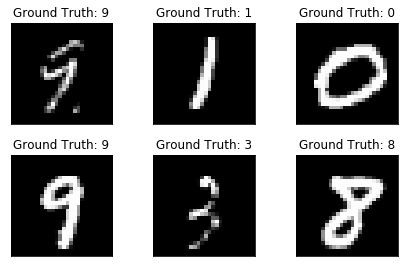

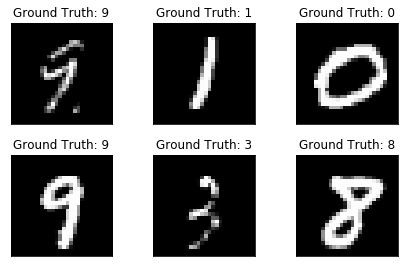

In [13]:
# Example
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [15]:
# Defining the classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [26]:
# Initializing
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [24]:
# Training and Testing Functions
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda()
    target = target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '../mnist/model.pth')
      #torch.save(optimizer.state_dict(), '../mnist/optimizer.pth')
    
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.cuda()
      target = target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [27]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-15-4e6311dd09c7>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3010, Accuracy: 1407/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313744
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.256570
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.286133
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.264976
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266302
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.254716
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.259275
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.187557
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.151111
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.160033
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.020181
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.917379
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.010235
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.868025
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.744523
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.573796
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.562862
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.364355
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.317939
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.307739
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.408797
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.354474
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.508602
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.283541
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.242345
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.260952
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.314736
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.324925
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.244699
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.331243
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.284252
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.457087
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.241624
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.208843
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.220436
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.629897
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.502434
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.275230
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.276395
